# Play with OpenVINO in jupyter notebook

Enviroment setup is done as described in [here](./enable_openvino_in_jupyter.md)

In [43]:
from openvino.preprocess import PrePostProcessor
import openvino.runtime as ov
import numpy as np

# this is top object
core = ov.Core()

for id, dev in enumerate(core.available_devices):
    v=core.get_versions(dev)[dev]
    print('[{}]:{} --- {} {}.{} ({})'.format(id, dev, v.description, v.major, v.minor, v.build_number))

[0]:CPU --- openvino_intel_cpu_plugin 2022.1 (custom_tq/CVS-74980_3de17de5e388f43df774d3ba55fc50fc9ef91a94)


## Model description API

ov.op/opset8/Model is for describing model using python. but this is not typical usage since openvino do not train NN.

In [86]:
# input
input_shape = [2, 3, 7, 7]
param_node = ov.op.Parameter(ov.Type.f32, ov.Shape(input_shape))
print('param_node: {}'.format(param_node))

# convolution weights in shape [out_channels, in_channels, kernel_height, kernel_width]
padding_begin = padding_end = [0, 0]
conv_kernel = ov.op.Constant(ov.Type.f32, ov.Shape([1,3,1,1]), np.ones([3]))
conv_node = ov.opset8.convolution(param_node, conv_kernel, [1, 1], padding_begin, padding_end, [1, 1])

# we can see shape inference happens immediatly
print('conv_node:{}'.format(conv_node))

maxpool_node = ov.opset1.max_pool(conv_node, [2, 2], padding_begin, padding_end, [2, 2], 'ceil')
relu_node = ov.opset8.relu(maxpool_node)

model = ov.Model(relu_node, [param_node], 'cnntest')

print('===================')
for op in model.get_ordered_ops():
    print(op)

param_node: <Parameter: 'Parameter_16149' ({2,3,7,7}, float)>
conv_node:<Convolution: 'Convolution_16151' ({2,1,7,7})>
<Parameter: 'Parameter_16149' ({2,3,7,7}, float)>
<Constant: 'Constant_16150' ({1,3,1,1})>
<Convolution: 'Convolution_16151' ({2,1,7,7})>
<MaxPool: 'MaxPool_16152' ({2,1,4,4})>
<Relu: 'Relu_16153' ({2,1,4,4})>
<Result: 'Result_16154' ({2,1,4,4})>


the `Model` here is high-level device-independent representation of CNN in openvino, most of the time user get this by converting from models of other NN frameworks.

# Model convert(import) APIs

src/bindings/python/src/pyopenvino/core/core.cpp

## Check supportiveness of a Model

Usually user just call compile_model() on a device w/o this step.

In [87]:
# returns  Pairs a operation name -> a device name supporting this operation.
for opname, devname in core.query_model(model, 'CPU').items():
    print("{} is supported by {}".format(opname, devname))

Constant_16150 is supported by CPU
Convolution_16151 is supported by CPU
MaxPool_16152 is supported by CPU
Parameter_16149 is supported by CPU
Relu_16153 is supported by CPU
Result_16154 is supported by CPU


## Compile model on particular device

In [89]:
compiled_model = core.compile_model(model, 'CPU')

# exported model is actually the IR in xml format
user_stream = compiled_model.export_model()
with open('./my_model', 'wb') as f:
    f.write(user_stream)

!echo "exported model is saved to " `realpath ./my_model`

# import_model also returns a compiled model
#core.import_model("./my_model",'CPU')

# runtime model is internal low-level executable graph for particular device
# although still a ngraph function, but it uses different set of op (`ExecutionNode`)
# to represent internal OP
print("=============runtime model=============")
runtime_model = compiled_model.get_runtime_model()
for op in runtime_model.get_ordered_ops():
    print(op)


exported model is saved to  /home/hddl/NN-runtimes/OpenVINO/my_model
=============runtime model=============
<Parameter: 'Parameter_16149' ({2,3,7,7}, float)>
<ExecutionNode: 'Constant_16150' ({1,3,1,1})>
<ExecutionNode: 'Constant_16150_abcd_Acdb8a_Convolution_16151' ({1,3,1,1})>
<ExecutionNode: 'Convolution_16151' ({2,1,7,7})>
<ExecutionNode: 'Convolution_16151_aBcd8b_abcd_MaxPool_16152' ({2,1,7,7})>
<ExecutionNode: 'MaxPool_16152' ({2,1,4,4})>
<Result: 'Result_16154' ({2,1,4,4})>


The APIs and relationships can be visualized as following:

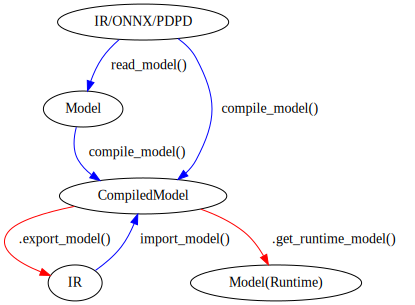

In [90]:
from graphviz import Digraph, Source
g = Digraph("openvino models relationship")
g.node(name='Model')
g.node(name='CompiledModel')
g.node(name='IR')
g.node(name='IR/ONNX/PDPD')
g.node(name='Model(Runtime)')

g.edge('Model','CompiledModel',label='compile_model()', color='blue')
g.edge('CompiledModel','IR',label='.export_model()', color='red')
g.edge('IR/ONNX/PDPD','CompiledModel',label='compile_model()', color='blue')
g.edge('IR/ONNX/PDPD','Model',label='read_model()', color='blue')
g.edge('IR','CompiledModel',label='import_model()', color='blue')
g.edge('CompiledModel','Model(Runtime)',label='.get_runtime_model()', color='red')

Source(g)

# Inference

 - src/bindings/python/src/pyopenvino/core/compiled_model.cpp

### check input/output information of the model

 - src/bindings/python/src/pyopenvino/graph/node_output.hpp

In [96]:
# check inputs & outputs (they are actually graph op)
# these are `ov::Output<const ov::Node>` type internally
for k, input in enumerate(compiled_model.inputs):
    print("inputs[{}]: {}".format(k,input))
for k, output in enumerate(compiled_model.outputs):
    print("outputs[{}]: {}".format(k,output))

inputs[0]: <ConstOutput: names[Parameter_16149] shape{2,3,7,7} type: f32>
<class 'openvino.pyopenvino.ConstOutput'>
outputs[0]: <ConstOutput: names[] shape{2,1,4,4} type: f32>


### Synchronously:  CompiledModel.infer_new_request()

Steps:
 - Create input `ov.Tensor`: src/bindings/python/src/pyopenvino/core/tensor.
 - Feed data into tensor
 - invoke `infer_new_request()`

 This is low-performance API

In [100]:
# get output description of the model
inode = compiled_model.input(0)

# numpy array can also be input of infer_new_request()
# but Tensor is best since it can interpret element_type correctly
input = ov.Tensor(inode.get_element_type(), inode.get_shape())

# the data member is numpy array wrapper of the tensor
# so we can manipulate data using numpy
input.data[0,:,:,:] = 1
input.data[1,:,:,:] = 2

# infer_new_request is synchronous API
# the key in input dict can be int/string/opNode
result = compiled_model.infer_new_request({0:input})
result = compiled_model.infer_new_request({'Parameter_16149':input})
result = compiled_model.infer_new_request({compiled_model.input(0):input})

print(result)

{<ConstOutput: names[] shape{2,1,4,4} type: f32>: array([[[[3., 3., 3., 3.],
         [3., 3., 3., 3.],
         [3., 3., 3., 3.],
         [3., 3., 3., 3.]]],


       [[[6., 6., 6., 6.],
         [6., 6., 6., 6.],
         [6., 6., 6., 6.],
         [6., 6., 6., 6.]]]], dtype=float32)}


### Asynchronously:  CompiledModel.infer_new_request()

 - src/bindings/python/src/pyopenvino/core/infer_request.cpp
 - src/bindings/python/src/pyopenvino/core/async_infer_queue.cpp

In [121]:
#infer_request = compiled_model.create_infer_request()
#infer_request.start_async()

def test_infer_queue(num_request, num_infer):
    infer_queue = ov.AsyncInferQueue(compiled_model, num_request)

    def callback(request, userdata):
        id = userdata

        #print("infer for id={}".format(id))
        #for k, tensor in enumerate(request.outputs):
        #    print("  output[{}]:  {} {}".format(k, tensor, tensor.data))

    infer_queue.set_callback(callback)

    for i in range(num_infer):
        input = ov.Tensor(inode.get_element_type(), inode.get_shape())
        input.data[:] = i
        infer_queue.start_async({0: input}, userdata=i)

    infer_queue.wait_all()

import time

for num_request in [64,8,1]:
    t0 = time.time()
    test_infer_queue(num_request, 1000)
    print("num_request={} time_used={} sec".format(num_request, time.time() - t0))

num_request=64 time_used=0.16123437881469727 sec
num_request=8 time_used=0.11992549896240234 sec
num_request=1 time_used=0.20255088806152344 sec


#dir(core)

'''
'add_extension',
 'available_devices',
 'compile_model',
 'get_config',
 'get_metric',
 'get_property',
 'get_versions',
 'import_model',
 'query_model',
 'read_model',
 'register_plugin',
 'register_plugins',
 'set_config',
 'set_property',
 'unload_plugin']
'''